<a href="https://colab.research.google.com/github/BhojRajBist/BhojRajBist/blob/main/Transparent_png_precipitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.7 MB/s eta 0:00:00
Generated TIFF URLs: ['https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070403F01O2024070400H003R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070406F02O2024070400H006R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070409F03O2024070400H009R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070412F04O2024070400H012R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070415F05O2024070400H015R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070418F06O2024070400H018R4KMC.tif', 'https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/20240704/NCMRWF_Nepal_2024070421F07O2024070400H021R4KMC.tif', 'https://storage.googleapis.com/ncmr

NameError: name 'FuncAnimation' is not defined

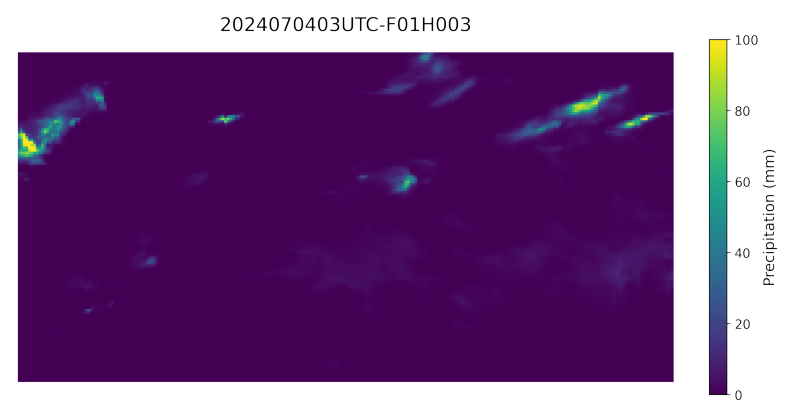

In [1]:
# Install the required libraries
!pip install rasterio pyproj pandas matplotlib imageio requests

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import imageio
from IPython.display import HTML
import requests

# Set root_dir to today's date in "YYYYMMDD" format
root_dir = datetime.today().strftime("%Y%m%d")

# Create the frames directory
frames_dir = os.path.join(root_dir, "FRAMES")
os.makedirs(frames_dir, exist_ok=True)

# Define the base URI
uri_base = f"https://storage.googleapis.com/ncmrwf-nepal/Forecast/NCMRWF/{root_dir}/"

# Define the forecast origin date
forecast_origin_date = datetime.strptime(root_dir, "%Y%m%d")

# Function to pad numbers
def pad2(num):
    return str(num).zfill(2)

def pad3(num):
    return str(num).zfill(3)

# Generate the list of URIs
tiff_urls = []
for i in range(1, 42):
    if i <= 25:
        time_step_hours = i * 3
        file_suffix = 'R4KMC.tif'
    else:
        time_step_hours = i * 3 - 2
        file_suffix = 'R12.5KMC.tif'

    time_step_str = pad3(time_step_hours)
    forecast_hour_index = pad2(i)
    forecast_time = forecast_origin_date + timedelta(hours=time_step_hours)
    forecast_time_str = forecast_time.strftime('%Y%m%d%H')

    uri = f"{uri_base}NCMRWF_Nepal_{forecast_time_str}F{forecast_hour_index}O{root_dir}00H{time_step_str}{file_suffix}"
    tiff_urls.append(uri)

print("Generated TIFF URLs:", tiff_urls)

# Function to download and save TIFF files
def download_tiff_files(urls, download_dir):
    tiff_files = []
    for url in urls:
        filename = os.path.join(download_dir, os.path.basename(url))
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            tiff_files.append(filename)
        else:
            print(f"Failed to download {url}")
    return tiff_files

# Download the TIFF files
tiff_files = download_tiff_files(tiff_urls, root_dir)
print("Downloaded TIFF files:", tiff_files)

# Function to plot precipitation data from TIFF files and save to PNG frames
def animate_precipitation_data_tiff_no_background(tiff_files):
    # Plot each TIFF file
    for i, file_path in enumerate(tiff_files):
        with rasterio.open(file_path) as src:
            precipitation = src.read(1)
            bounds = src.bounds

            fig, ax = plt.subplots(figsize=(12, 8))
            im = ax.imshow(precipitation, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=100)
            ax.axis('off')  # Turn off the axis

            # Add title and colorbar
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            timestamp = parts[2].split('F')[0]  # Extract timestamp
            forecastIndex = parts[2].split('F')[1].split('O')[0]  # Extract forecast index
            forecastHrsPart = parts[2].split('H')[1]  # Extract forecast hours part
            forecastHrs = forecastHrsPart.split('R')[0]  # Extract forecast hours
            title = timestamp + 'UTC-F' + forecastIndex + 'H' + forecastHrs
            ax.set_title(title, fontsize=18, pad=20)

            norm = mcolors.Normalize(vmin=0, vmax=100)
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, fraction=0.025, norm=norm)
            cbar.set_label('Precipitation (mm)', fontsize=14)
            cbar.ax.yaxis.set_tick_params(labelsize=12)  # Adjust font size of color bar values

            # Save each frame with transparent background
            frame_filename = os.path.join(frames_dir, f'frame_{i:04d}.png')
            plt.savefig(frame_filename, bbox_inches='tight', dpi=400, transparent=True)
            plt.close(fig)

    print("Frames saved successfully.")

    # Create an animated GIF from the frames with a delay between frames
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    gif_filename = os.path.join(root_dir, f'precipitation_animation_{root_dir}.gif')
    with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:  # 1-second delay
        for frame_file in frame_files:
            image = imageio.v2.imread(frame_file)
            writer.append_data(image)

    print(f"Animation saved as {gif_filename}.")

    # Function to update each frame
    def update(frame):
        im.set_data(plt.imread(frame_files[frame]))
        return im,

    # Create a figure without the outer frame
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis

    # Display the first frame
    im = ax.imshow(plt.imread(frame_files[0]))

    # Create the animation with the specified interval
    ani = FuncAnimation(fig, update, frames=len(frame_files), interval=1000)

    # Display the animation
    return HTML(ani.to_html5_video())

# Function to extract PNG frames with precipitation data, legend, and title only
def extract_png_frames(frames_dir, output_dir):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through frame files in frames_dir
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    for i, frame_file in enumerate(frame_files):
        # Load the frame image
        image = plt.imread(frame_file)

        # Create a new figure without the outer frame
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis('off')  # Turn off the axis

        # Display only the precipitation data, legend, and title
        ax.imshow(image, alpha=0)  # Set alpha to 0 to make the background transparent

        # Save the modified frame with transparent background
        output_file = os.path.join(output_dir, f'frame_{i:04d}.png')
        plt.savefig(output_file, bbox_inches='tight', dpi=400, transparent=True)
        plt.close(fig)

    print(f"PNG frames extracted to {output_dir}.")

# Call the function to plot precipitation data without background and save frames
animate_precipitation_data_tiff_no_background(tiff_files)

# Extract the frames with transparent background
frames_dir = '20240704/FRAMES'  # Update with your frames directory
output_frames_dir = '20240704/extracted_frames'  # Update with your output directory
extract_png_frames(frames_dir, output_frames_dir)
